# Tensorflow: vattenfall

**Deep learning to model transient dynamics of hydro Turbine**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# plt.style.use(['science','no-latex'])
# plt.rcParams["font.family"] = "Times New Roman"
%load_ext autoreload
%autoreload 2

import tensorflow as tf

## 1, Load the data

In [4]:
#from tensorflow import keras
#from google.colab import drive
#drive.mount('/content/drive')
#df = pd.read_csv('/content/drive/MyDrive/Data/vattenfall_turbine.csv')
#drive.flush_and_unmount()
#print('NB: Unmount the google cloud driver')

df = pd.read_csv(r'E:\FEM\Python\bitbucket\Vattenfall_rnn\vattenfall_turbine.csv')
keys = df.keys().values
feature_keys = keys[np.arange(1,5).tolist() + np.arange(7,10).tolist()]
time_key = keys[0]

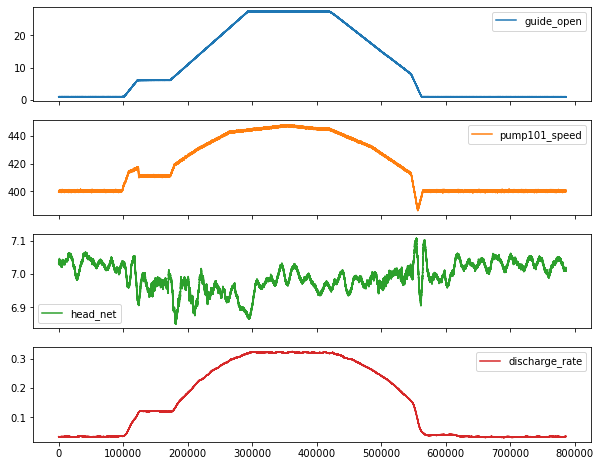

<span style="color:blue;font-size:50px">**Lets take a close look at the time series.**</span>

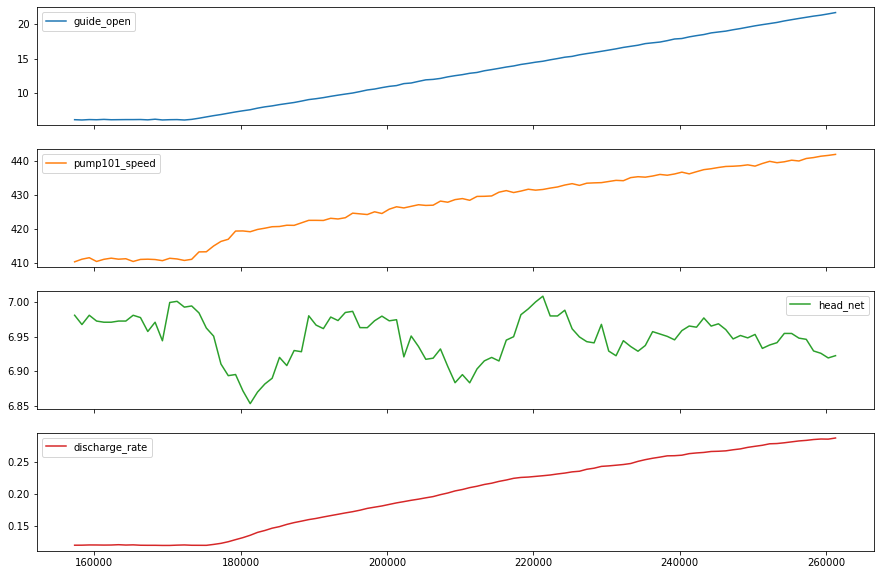

In [5]:
plot_cols = feature_keys[0:len(feature_keys):2]
plot_features = df[plot_cols]
#plot_features.index = df[time_key]
fig1 = plot_features.plot(subplots=True, figsize=(10, 8))
plt.show()

from IPython.display import display, Markdown
#display(Markdown(' <font size="6"><span style="color:blue">**Lets take a close look at the time series.**</span> </font>'))

display(Markdown('<span style="color:blue;font-size:50px">**Lets take a close look at the time series.**</span>'))

plot_features = df[plot_cols][int(len(df)/5):int(len(df)/3):1000]
#plot_features.index = df[time_key][:480]
fig2 = plot_features.plot(subplots=True, figsize=(15, 10))

## 2, Preprocessing data: normalize, train, validation, test, etc.

### 2.1, resample the data with low-resolution

<span style="color:red; font-size:30px">**No. of the values in the training dataset is: 1967**</span>

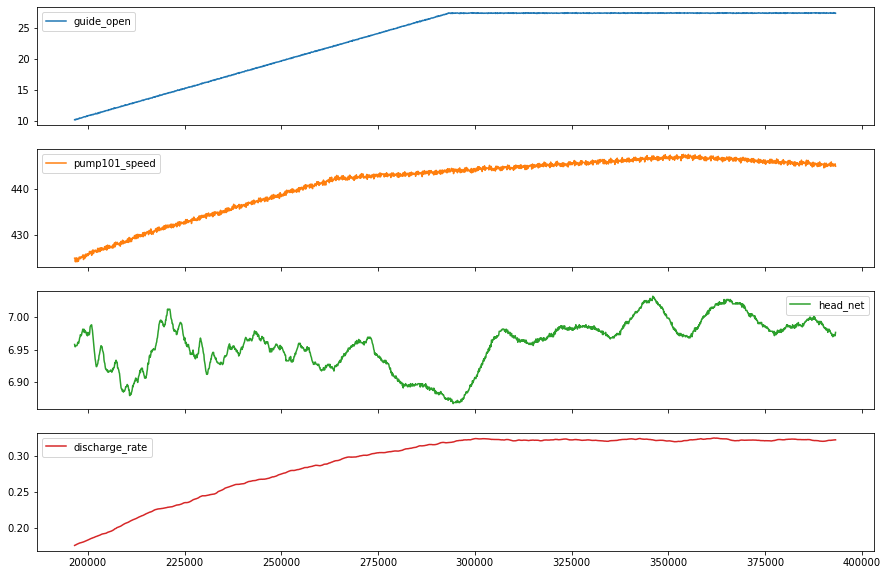

<span style="color:blue; font-size:20px">**Plot the heatmap for variation of standard deviation**</span>

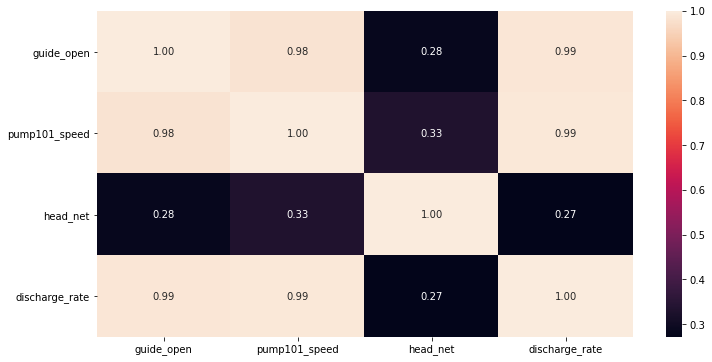

In [6]:
df_train = df[feature_keys[0:7:2]][int(len(df)/4):int(len(df)/2):100]
display(Markdown('<span style="color:red; font-size:30px">**No. of the values in the training dataset is: %d**</span>' %len(df_train)))

# plot the data and check their variations along time
df_train.plot(subplots=True, figsize=(15, 10))
plt.show()
#print('No. of the values in the training dataset is: %d' %len(df_train))

display(Markdown('<span style="color:blue; font-size:20px">**Plot the heatmap for variation of standard deviation**</span>'))
# check he correlation
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(df_train.corr(), annot=True, fmt=".2f")
plt.show()

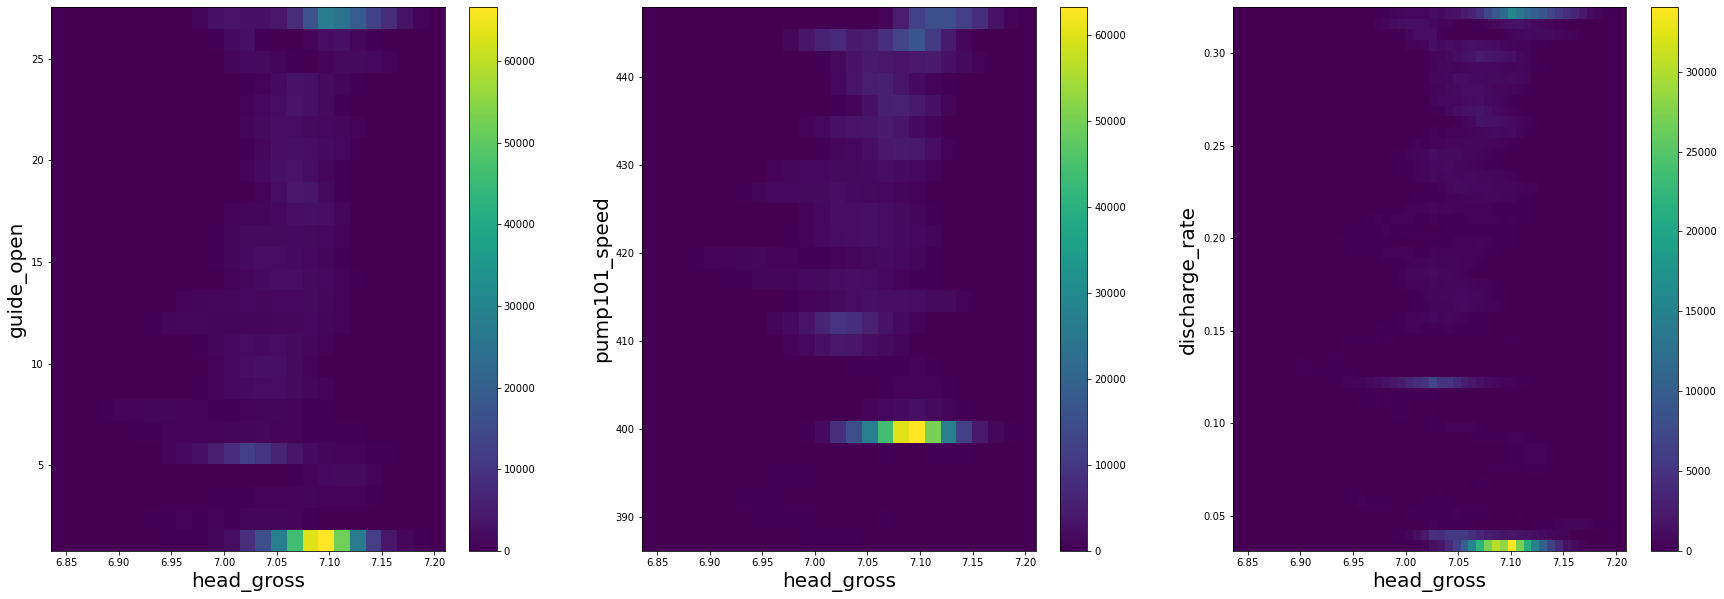

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors, ticker, cm


fig = plt.figure(figsize=(30, 10))
fig.add_subplot(131)
plt.hist2d(df['head_gross'], df['guide_open'], bins=(25, 25))
plt.xlabel('head_gross', size=20)
plt.ylabel('guide_open', size=20)
plt.colorbar()

fig.add_subplot(132)
plt.hist2d(df['head_gross'], df['pump101_speed'], bins=(25, 25))
plt.xlabel('head_gross', size=20)
plt.ylabel('pump101_speed', size=20)
plt.colorbar()

fig.add_subplot(133)
plt.hist2d(df['head_gross'], df['discharge_rate'], bins=(50, 50))
plt.xlabel('head_gross', size=20)
plt.ylabel('discharge_rate', size=20)
plt.colorbar()



In [8]:
features = df.keys()
features

Index(['time', 'guide_open', 'running_speed', 'pump101_speed', 'pump102_speed',
       'pump101_set', 'pump102_set', 'head_net', 'head_gross',
       'discharge_rate', 'unknow_Hg', 'unknow_Hst', 'unknow_Qt',
       'unknown_Pabs'],
      dtype='object')

### 2.2, autocorrelation function (ACF) and (PACF) to check time dependence

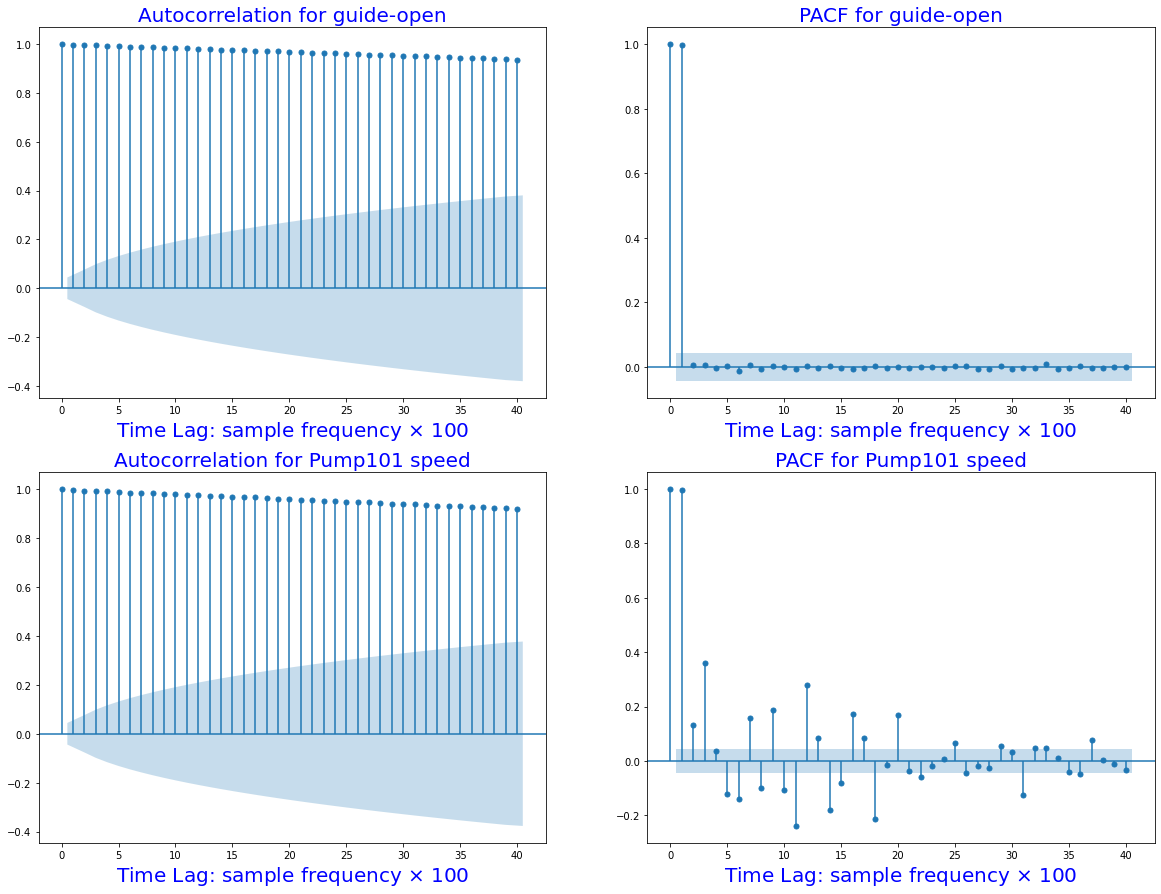

In [9]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]

acf_open = autocorr(df_train.guide_open)


from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

fig, ax = plt.subplots(2,2,figsize=(20,15))
sm.graphics.tsa.plot_acf(df_train.guide_open.squeeze(), lags=40, ax=ax[0,0])
ax[0,0].set_title("Autocorrelation for guide-open", fontsize=20, color='blue')
ax[0,0].set_xlabel(r'Time Lag: sample frequency $\times$ 100', fontsize=20, color='blue')

sm.graphics.tsa.plot_pacf(df_train.guide_open.squeeze(), lags=40, ax=ax[0, 1])
ax[0,1].set_title("PACF for guide-open", fontsize=20, color='blue')
ax[0,1].set_xlabel(r'Time Lag: sample frequency $\times$ 100', fontsize=20, color='blue')

sm.graphics.tsa.plot_acf(df_train.pump101_speed.squeeze(), lags=40, ax=ax[1,0])
ax[1,0].set_title("Autocorrelation for Pump101 speed", fontsize=20, color='blue')
ax[1,0].set_xlabel(r'Time Lag: sample frequency $\times$ 100', fontsize=20, color='blue')

sm.graphics.tsa.plot_pacf(df_train.pump101_speed.squeeze(), lags=40, ax=ax[1,1])
ax[1,1].set_title("PACF for Pump101 speed", fontsize=20, color='blue')
ax[1,1].set_xlabel(r'Time Lag: sample frequency $\times$ 100', fontsize=20, color='blue')
plt.show()

### 2.3 crossing autocorrelationship for various parameters

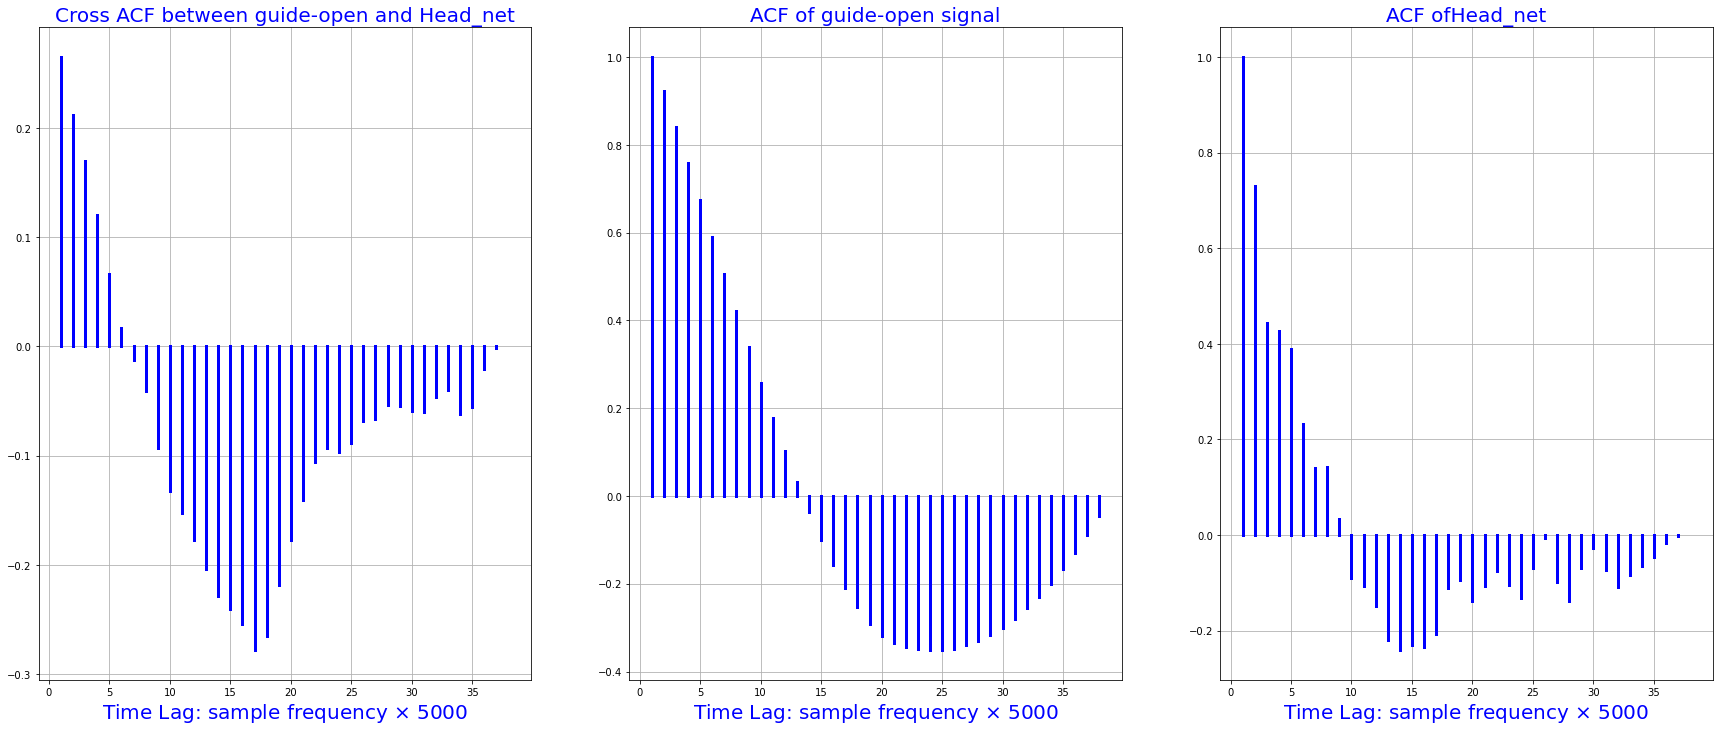

In [10]:
# NB: we have resampled the data for the autocorreltion analysis

import statsmodels.tsa.stattools as smt
xacf = smt.ccf(df_train.guide_open.squeeze()[0:1900:50], df_train.head_net.squeeze()[0:1900:50],  adjusted=False)
acf1 = smt.ccf(df_train.guide_open.squeeze()[0:1900:50], df_train.guide_open.squeeze()[0:1900:50],  adjusted=False)
acf2 = smt.ccf(df_train.head_net.squeeze()[0:1900:50], df_train.head_net.squeeze()[0:1900:50],  adjusted=False)


fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharex=True, figsize=(30,12))
i = 1
for p in xacf:
    x = [i, i]
    ax1.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax1.grid(True)
ax1.set_title("Cross ACF between guide-open and Head_net", fontsize=20, color='blue')
ax1.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')


i = 1
for p in acf1:
    x = [i, i]
    ax2.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax2.grid(True)
ax2.set_title("ACF of guide-open signal", fontsize=20, color='blue')
ax2.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')

i = 1
for p in acf2:
    x = [i, i]
    ax3.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax3.grid(True)
ax3.set_title("ACF ofHead_net", fontsize=20, color='blue')
ax3.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')

plt.show()

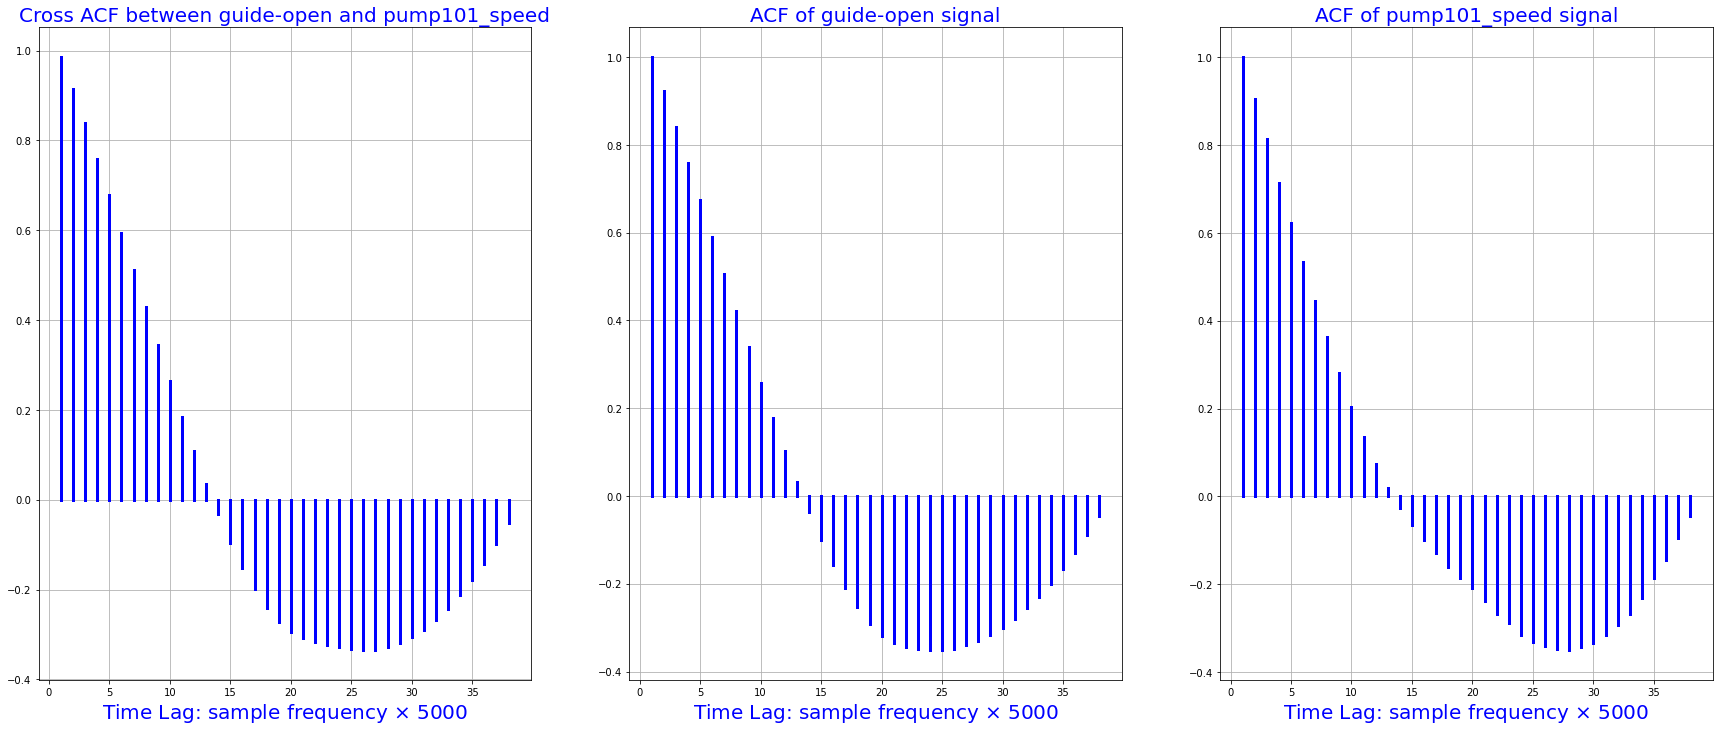

In [11]:
# Autocorrelation between guide_opan and pump101_speed
xacf = smt.ccf(df_train.guide_open.squeeze()[0:1900:50], df_train.pump101_speed.squeeze()[0:1900:50],  adjusted=False)
acf1 = smt.ccf(df_train.guide_open.squeeze()[0:1900:50], df_train.guide_open.squeeze()[0:1900:50],  adjusted=False)
acf2 = smt.ccf(df_train.pump101_speed.squeeze()[0:1900:50], df_train.pump101_speed.squeeze()[0:1900:50],  adjusted=False)


fig, [ax1, ax2, ax3] = plt.subplots(1, 3, sharex=True, figsize=(30,12))
i = 1
for p in xacf:
    x = [i, i]
    ax1.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax1.grid(True)
ax1.set_title("Cross ACF between guide-open and pump101_speed", fontsize=20, color='blue')
ax1.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')


i = 1
for p in acf1:
    x = [i, i]
    ax2.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax2.grid(True)
ax2.set_title("ACF of guide-open signal", fontsize=20, color='blue')
ax2.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')



i = 1
for p in acf2:
    x = [i, i]
    ax3.plot([i, i], [0, p],  'b', linewidth=3)
    i= i + 1
ax3.grid(True)
ax3.set_title("ACF of pump101_speed signal", fontsize=20, color='blue')
ax3.set_xlabel(r'Time Lag: sample frequency $\times$ 5000', fontsize=20, color='blue')



plt.show()

### 2.4, normalize the data

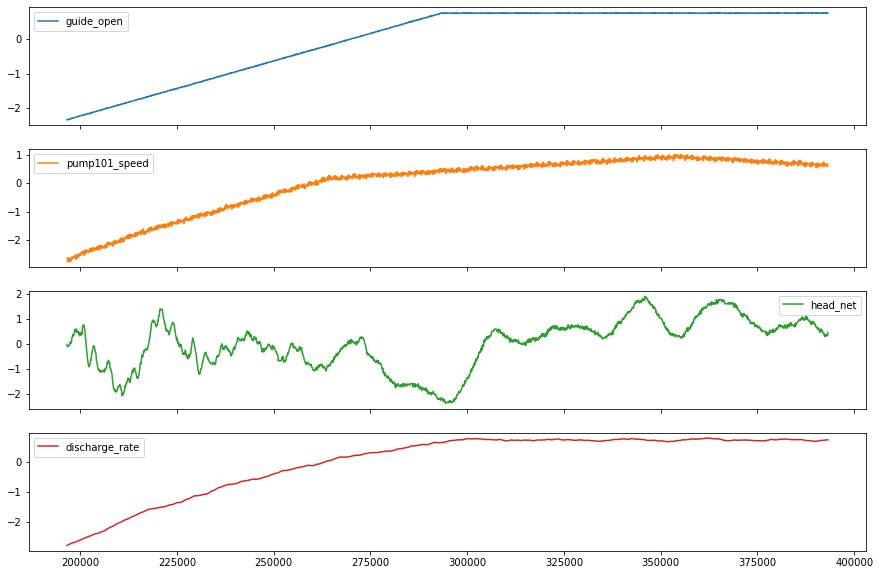

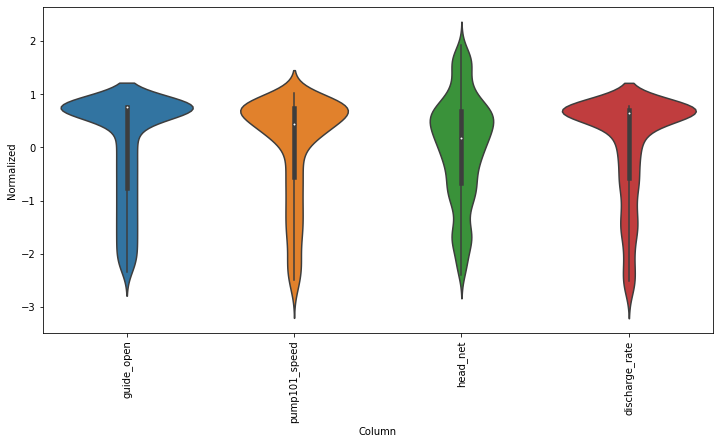

In [12]:
# First, we assume all data are used for the training (the time series is not that stationary for the prediction)
df_train_mean = df_train.mean()
df_train_std = df_train.std()
train_df = (df_train-df_train_mean) / df_train_std

fig2 = train_df.plot(subplots=True,figsize=(15,10))

# Second, plot the standand deviation of features within this dataframe
df_std = train_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
fig3 = ax.set_xticklabels(train_df.keys(), rotation=90)

In [13]:
# tf.convert_to_tensor(new_df)
new_df = train_df.reset_index(drop=True)
target = new_df.pop('guide_open')
#new_df.head()
target.head()
new_df = tf.convert_to_tensor(new_df)

#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(numeric_features)

In [14]:
feature_keys

array(['guide_open', 'running_speed', 'pump101_speed', 'pump102_speed',
       'head_net', 'head_gross', 'discharge_rate'], dtype=object)

## 3, Understand the dataset construction and build basic models (treated as independent dataset)

In [15]:
df_train = df[feature_keys][int(len(df)/4):int(len(df)/2):100]

df_train = df_train.reset_index(drop=True)
#df_train.pop('time')
df_train.pop('head_net')
df_target = df_train.pop('head_gross')
df_train.head()


,guide_open,running_speed,pump101_speed,pump102_speed,discharge_rate
0,10.258026,883.147506,424.766713,423.792913,0.175680
1,10.220808,883.147506,424.633645,424.918785,0.176028
2,10.313853,882.934738,423.968301,425.084355,0.176227
3,10.302687,883.041122,424.567110,424.422077,0.176376
4,10.354793,883.041122,424.866515,424.157165,0.176774


In [16]:
# Pre-normalize the features for ML analysis
norm = tf.keras.layers.Normalization(axis=-1)
norm.adapt(df_train)
tf_train = norm(df_train)

# normalize the target (output)
norm_target = tf.keras.layers.Normalization(axis=None)
norm_target.adapt(df_target)
tf_target = norm_target(df_target)

# configure the model
BATCH_SIZE = 500

def get_basic_model():
  model = tf.keras.Sequential([
    norm,
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

model = get_basic_model()
model.fit(tf_train, tf_target, epochs=10, batch_size=BATCH_SIZE)

Epoch 1/10
4/4 [==============================] - 1s 4ms/step - loss: 23.7285 - accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.3162 - accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.8179 - accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2230 - accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.7362 - accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.0784 - accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2511 - accuracy: 0.0000e+00
Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: -0.0369 - accuracy: 0.0000e+00
Epoch 9/10
4/4 [==============================] - 0s 4ms/step - loss: -0.2754 - accuracy: 0.0000e+00
Epoch 10/10
4/4 [==============================] - 0s 4ms/step - loss: -0.2687 - accuracy: 0.0000

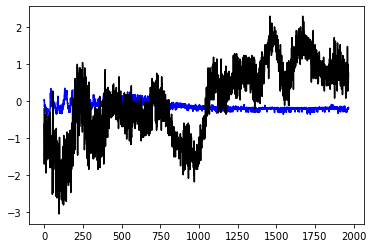

In [17]:
plt.plot(model.predict(df_train),'b')
plt.plot(tf_target,'k')
plt.show()

In [18]:
norm1 = tf.keras.layers.Normalization(axis =-1)
norm1.adapt(df_train)
tf_train = norm1(df_train)

norm2 = tf.keras.layers.Normalization(axis = None)
norm2.adapt(df_target)
tf_target= norm2(df_target)

dataset_df = tf.data.Dataset.from_tensor_slices((tf_train, tf_target))
dataset_batches = dataset_df.shuffle(100).batch(BATCH_SIZE)

model = get_basic_model()
model.fit(dataset_batches, epochs=10)

Epoch 1/10
4/4 [==============================] - 0s 4ms/step - loss: 523.7493 - accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 0s 5ms/step - loss: 109.0707 - accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 5ms/step - loss: 55.5138 - accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 5ms/step - loss: 33.8233 - accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 22.7980 - accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 16.3655 - accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 4ms/step - loss: 12.2998 - accuracy: 0.0000e+00
Epoch 8/10
4/4 [==============================] - 0s 4ms/step - loss: 9.7406 - accuracy: 0.0000e+00
Epoch 9/10
4/4 [==============================] - 0s 4ms/step - loss: 7.8712 - accuracy: 0.0000e+00
Epoch 10/10
4/4 [==============================] - 0s 4ms/step - loss: 7.0274 - accuracy: 0

### 3.2, Understand datastructure of the tensorflow package --> formulate rolling windowed dataset --> for model in Section 4

<ipython-input-19-bf96d0c125a6>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 30)


[Text(0, -6.0, '-6.0'),
 Text(0, -4.0, '-4.0'),
 Text(0, -2.0, '-2.0'),
 Text(0, 0.0, '0.0'),
 Text(0, 2.0, '2.0'),
 Text(0, 4.0, '4.0')]

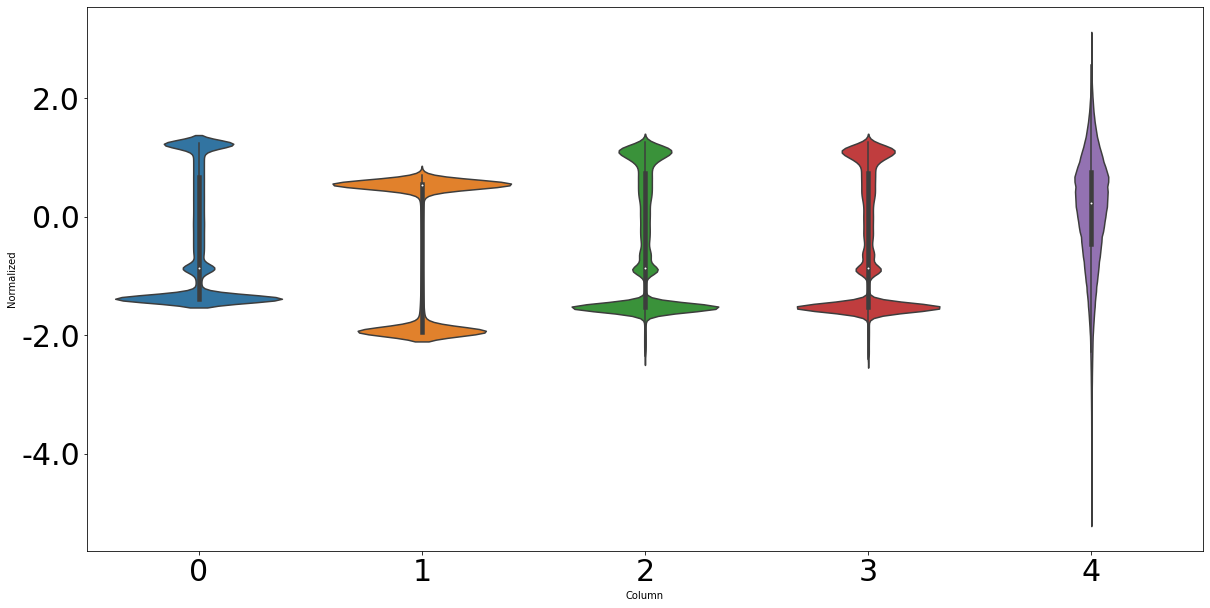

In [19]:
# split the time series of data into train (70%), test (20%) and validation (10%)
#n = len(df_train)
df_train = df[feature_keys]
df_train.pop('head_net')
df_train.pop('discharge_rate')
n = len(df_train)
# start to divide them
train_df = df_train[0:int(n*0.7)]
test_df = df_train[int(n*0.7):int(n*0.9)]
val_df = df_train[int(n*0.9):]
df_train.shape[1]

## Tensorflow dataset donot have buildin functions to estimate the mean and standard deviation
#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(train_df)
#train_df = normalizer(train_df)

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean)/train_std
test_df = (test_df - train_mean)/train_std
val_df = (val_df - train_mean)/train_std

df_std = (df_train - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

fig, ax = plt.subplots(figsize=[20, 10])
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
ax.set_xticklabels(ax.get_xticks(), size = 30)
ax.set_yticklabels(ax.get_yticks(), size = 30)

## <span style ="color:blue; font-size:25px"> **4, Dataset (rolling/windowed dataset) for time series analysis**</span>

### 4.1, Read data into the data class

In [20]:
# 4.1.1, Indexes and offsets

## NB: the data for training, testing and validation should be store here first!!
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# 4.1.2, Split the window
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


# 4.1.3, plot the time series  ################# NB: this also needs to set up the label/output parameter
def plot(self, model=None, plot_col='head_gross', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [minisecond]')

WindowGenerator.plot = plot

### 4.2, Check the constructed basic dataset class

In [21]:
# Test of windowed dataset 

#w0 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['head_gross'])
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=None)
w=w1

# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w.total_window_size]),
                           np.array(train_df[100:100+w.total_window_size]),
                           np.array(train_df[200:200+w.total_window_size])])

example_inputs, example_labels = w.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 5)
Inputs shape: (3, 24, 5)
Labels shape: (3, 1, 5)


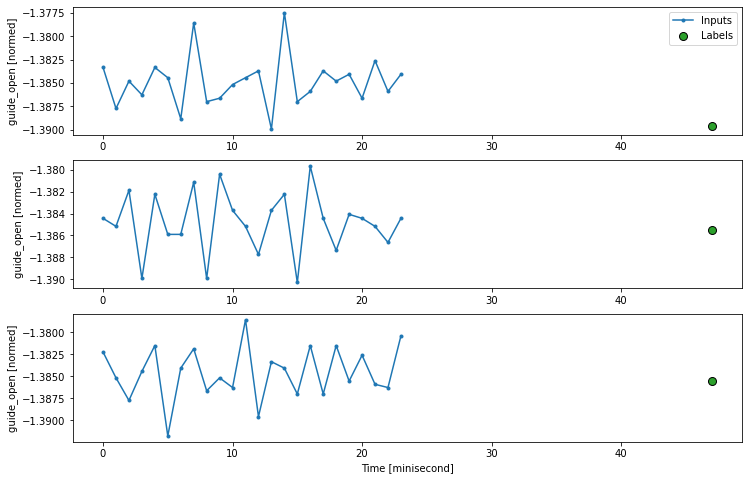

In [22]:
w.example = example_inputs, example_labels
w.plot(plot_col='guide_open')

### <span style ="color:blue; font-size:25px"> **4.3, Formulate train, test, validation datasets in the data structure**</span>

In [23]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

# add properties to the dataset
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Run the example to get the index
for example_inputs, example_labels in w.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 5)
Labels shape (batch, time, features): (32, 1, 5)


In [24]:
for example_inputs, example_labels in w.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 24, 5)
Labels shape (batch, time, features): (32, 1, 5)


## 5, **Single step model: $$Head\_t = f(guide\_open_{(t-1, t-2, ...)}, pump\_speed_{(t-1, t-2, ...)}, discharge\_rate_{(t-1, t-2, ...)},...)$$**

### 5.1, Baseline and linear models
| <span style = "color: red; font-weight: 500; font-size: 20px"> Baseline narrow window </span> | <span style = "color: red; font-weight: 500; font-size: 20px">Baseline wide window </span> | <span style = "color: blue; font-weight: 500; font-size: 20px">Linear model with narrow window</span> | <span style = "color: blue; font-weight: 500; font-size: 20px"> Linear model with wide window </span> |
|:----------:|:-------------:|:-------------:|:------:|
| ![baseline](./images/baseline.png) |  ![baselinenarrow](./images/baseline_wide_window.png) | ![linenarrow](./images/linear_narrow_window.png) | ![linewide](./images/linear_wide_window.png) |


#### Test 1: narrow window dataset (single output window)

In [25]:
# Get the first dataset (all features as output)
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns = ['head_gross']) # we can set "label_columns=None"
single_step_window

for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
    
single_step_window.label_columns, single_step_window.column_indices

Inputs shape (batch, time, features): (32, 1, 5)
Labels shape (batch, time, features): (32, 1, 1)


(['head_gross'],
 {'guide_open': 0,
  'running_speed': 1,
  'pump101_speed': 2,
  'pump102_speed': 3,
  'head_gross': 4})

In [26]:
# Baseline model
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

# Build the model
baseline = Baseline(label_index=single_step_window.column_indices['head_gross'])

#baseline = Baseline(label_index=None)

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2458/2458 [==============================] - 4s 2ms/step - loss: 0.0034 - mean_absolute_error: 0.0432


In [27]:
single_step_window.test

<MapDataset shapes: ((None, 1, 5), (None, 1, 1)), types: (tf.float32, tf.float32)>

#### Test 2: wide output window

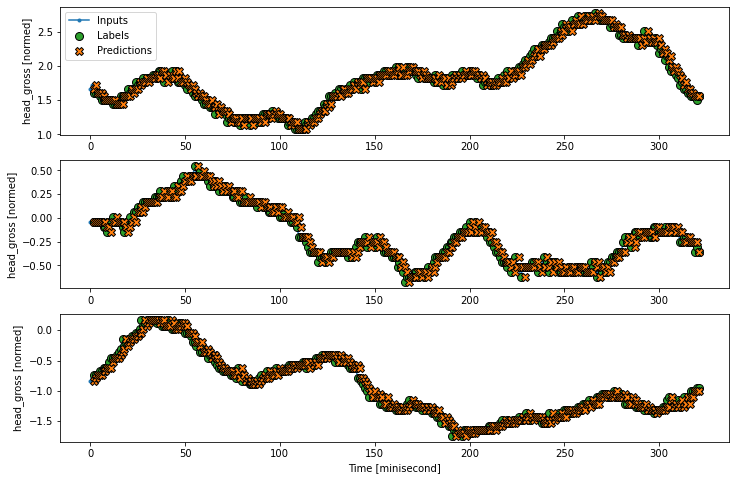

In [28]:
wide_window = WindowGenerator(
    input_width=320, label_width=320, shift=2,
    label_columns=['head_gross'])    ################# NB: it is very important to choose the parameters here ##############
###################################################################################################################################

wide_window.plot(baseline)

**From above analysis, it should be remarked**
* it is important to keep "baseline = Baseline(label_index=single_step_window.column_indices['head_gross'])" 
* the index should be the same as the WindowGenerator function!!***

### 5.2, Linear model with narrow window dataset <span style = "background: yellow">"WindowGenerator(input_width=1, label_width=1, shift=1)"</span>

Input shape: (32, 1, 5)
Output shape: (32, 1, 1)


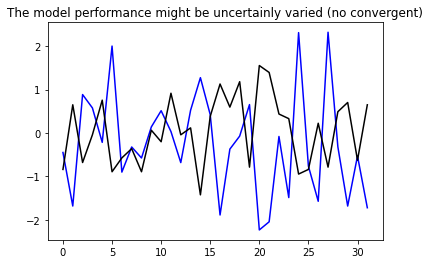

In [29]:
# define linear model from the package
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

# Check the linear model
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

# Plot the result to check the linear model
plt.plot(linear(single_step_window.example[0]).numpy().flatten(), 'b') 
plt.plot(single_step_window.example[1].numpy().flatten(), 'k')
plt.title('The model performance might be uncertainly varied (no convergent)')
plt.show()

In [30]:
MAX_EPOCHS = 3

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/3
17204/17204 [==============================] - 54s 3ms/step - loss: 0.1395 - mean_absolute_error: 0.1352 - val_loss: 0.0035 - val_mean_absolute_error: 0.0460
Epoch 2/3
17204/17204 [==============================] - 52s 3ms/step - loss: 0.0037 - mean_absolute_error: 0.0467 - val_loss: 0.0034 - val_mean_absolute_error: 0.0449
Epoch 3/3
2458/2458 [==============================] - 5s 2ms/step - loss: 0.0036 - mean_absolute_error: 0.0486


Text(0.5, 1.0, 'NB: the linear model is the same as the optimized in the history, which is diferent from the above one using only one running')

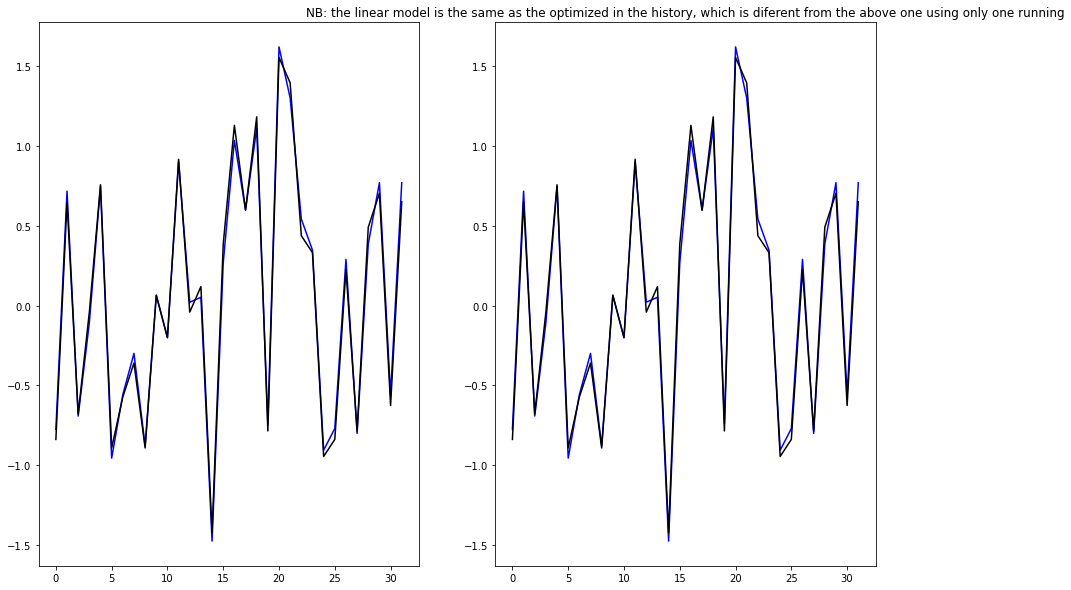

In [31]:
# Two ways to plot the results

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [15, 10])
# first plot based on the iteractive model
ax1.plot(history.model.predict(single_step_window.example[0]).flatten(),'b')
ax1.plot(single_step_window.example[1].numpy().flatten(), 'k')

# second plot based on the 
ax2.plot(linear(single_step_window.example[0]).numpy().flatten(), 'b') 
ax2.plot(single_step_window.example[1].numpy().flatten(), 'k')
ax2.set_title("NB: the linear model is the same as the optimized in the history, which is diferent from the above one using only one running")


### 5.3, linear model for wide window data inputs <span style = "background: yellow">"WindowGenerator(input_width=300, label_width=300, shift=1)"</span>

Input shape: (32, 320, 5)
Output shape: (32, 320, 1)


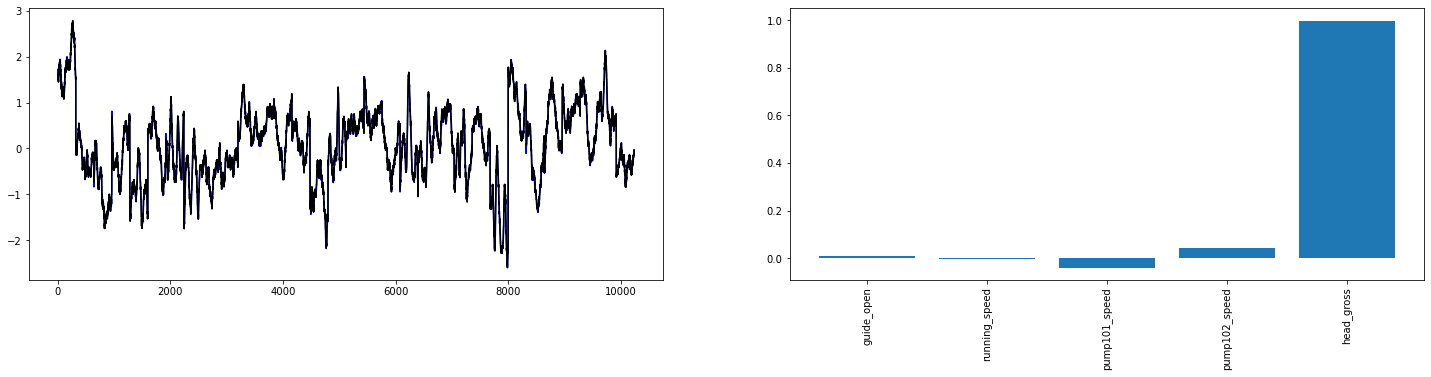

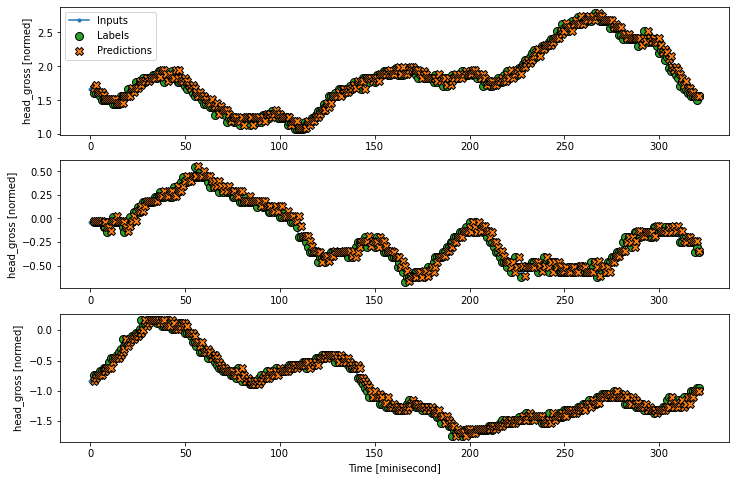

In [32]:
# Plot the result to check the linear model
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,5))
ax1.plot(linear(wide_window.example[0]).numpy().flatten(), 'b') 
ax1.plot(wide_window.example[1].numpy().flatten(), 'k')


# plot the weight bars used in this model
ax2.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
#axis = plt.gca()
ax2.set_xticks(range(len(train_df.columns)))
_ = ax2.set_xticklabels(train_df.columns, rotation=90)
#plt.show()

# Lets make the wider window dataset
wide_window.plot(linear)
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

### 5.4, Dense model (multiple layers and activation function)

 ![dense_dataset](./images/dense_dataset.png)
 
**Multi-step dense dataset structure** 




Epoch 1/3
17204/17204 [==============================] - 79s 5ms/step - loss: 0.0047 - mean_absolute_error: 0.0508 - val_loss: 0.0042 - val_mean_absolute_error: 0.0525
Epoch 2/3
17204/17204 [==============================] - 78s 5ms/step - loss: 0.0038 - mean_absolute_error: 0.0486 - val_loss: 0.0035 - val_mean_absolute_error: 0.0462
Epoch 3/3
2458/2458 [==============================] - 8s 3ms/step - loss: 0.0034 - mean_absolute_error: 0.0447


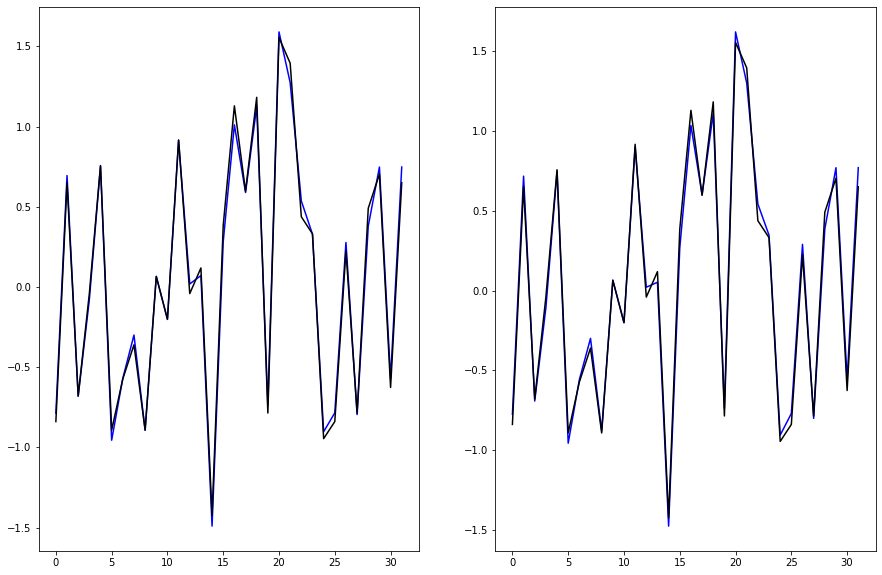

In [33]:
# model construction and estimation
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

# plot the results
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [15, 10])
# first plot based on the iteractive model
ax1.plot(history.model.predict(single_step_window.example[0]).flatten(),'b')
ax1.plot(single_step_window.example[1].numpy().flatten(), 'k')

# second plot based on the 
ax2.plot(linear(single_step_window.example[0]).numpy().flatten(), 'b') 
ax2.plot(single_step_window.example[1].numpy().flatten(), 'k')


## 6, **CNN Model construction for $x_t = f(X_{t-1}, X_{t-2}, X_{t-3},...)$**

### 6.1, Set up the convolutional neuron network (CNN) dataset.
![RNN_Data_Structrue](./images/cnn_dataset.png)

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['head_gross']


Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

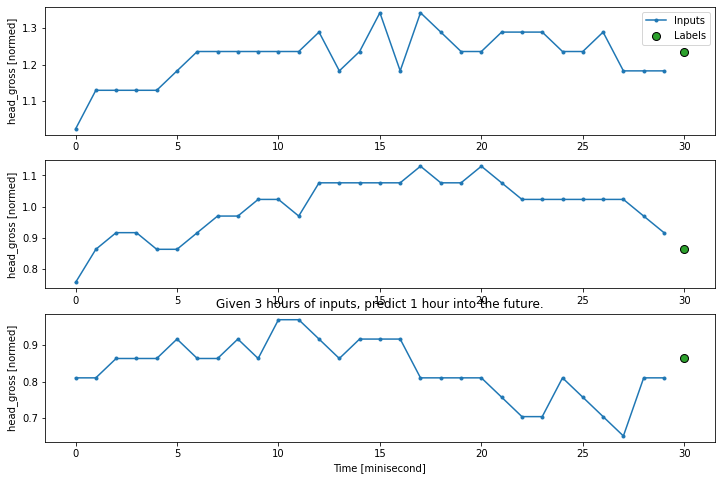

In [34]:
# Create the indexes
CONV_WIDTH = 30
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['head_gross'])

print(conv_window)

# plot the input data/features
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

### 6.2, Test for the "multiple-steps model" model 
(Using CNN data structure) -- <span style = "color: blue; font-size: 20px"> Narrow window: input_width = 3</span>

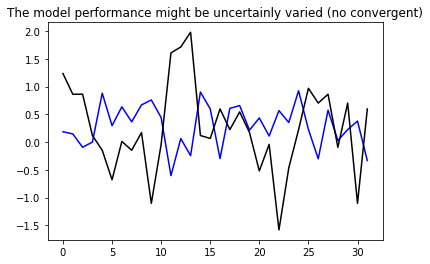

In [35]:
# configure the model
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

# Plot the result to check the linear model
plt.plot(multi_step_dense(conv_window.example[0]).numpy().flatten(), 'b') 
plt.plot(conv_window.example[1].numpy().flatten(), 'k')
plt.title('The model performance might be uncertainly varied (no convergent)')
plt.show()

2457/2457 [==============================] - 5s 2ms/step - loss: 0.0028 - mean_absolute_error: 0.0424


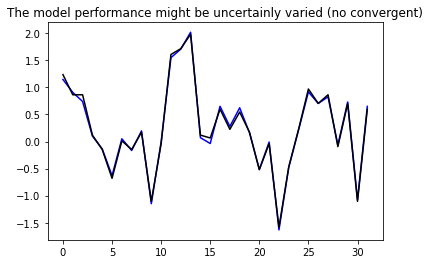

In [36]:
# optimise the model through "compile_and_fit"
import IPython

history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

# Plot the result to check the linear model
plt.plot(history.model.predict(conv_window.example[0]).flatten(), 'b') 
plt.plot(conv_window.example[1].numpy().flatten(), 'k')
plt.title('The model performance might be uncertainly varied (no convergent)')
plt.show()

### 6.3, Convolutional Neuron Network:

<span style = "color: blue; font-size: 20px"> Narrow window: input_width = CONV_width = 3</span>
Difference between multi-step dense model and CNN model
* model construction: CNN model require input_width, but no need for layers.flatten() and layers.reshape([1, -1])
* data structure: output of CNN datastructure is (#input_window -1) dimensions less

In [37]:
# Configure the CNN model
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

# Estimate the CNN model
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

2457/2457 [==============================] - 8s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0449


Wide window
Input shape: (32, 320, 5)
Labels shape: (32, 320, 1)
Output shape: (32, 291, 1)


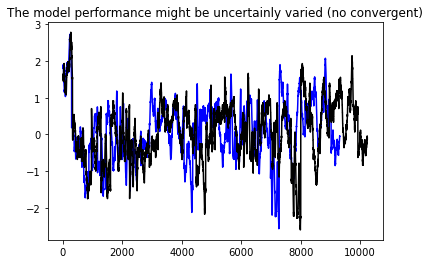

In [38]:
# Check the length difference between multiple-step-dense model and the CNN model
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

#  Plot the result to check the linear model
plt.plot(history.model.predict(wide_window.example[0]).flatten(), 'b') 
plt.plot(wide_window.example[1].numpy().flatten(), 'k')
plt.title('The model performance might be uncertainly varied (no convergent)')
plt.show()

### 6.4, Convolutional Neuron Network 

<span style = "color: blue; font-size: 20px"> Wide window: input_width = CONV_width = 30</span>


Wide conv window
Input shape: (32, 53, 5)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


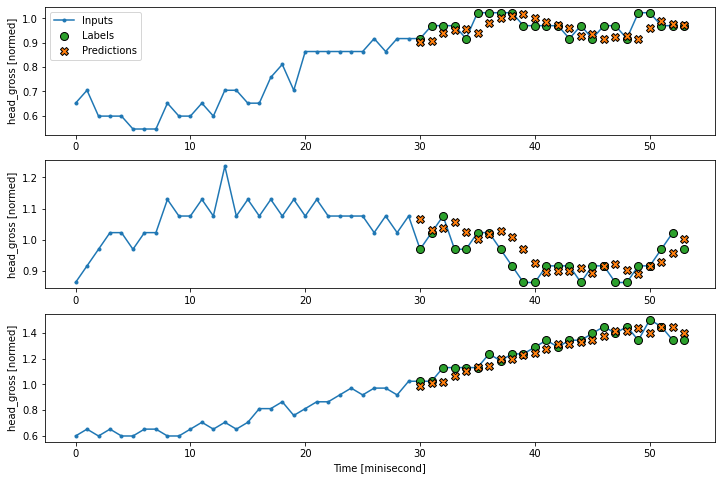

In [39]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['head_gross'])

wide_conv_window
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)
wide_conv_window.plot(conv_model)


### 6.5 Recurrent Neuron Network (RNN)
**In this example test, we will use the LSTM of RNN for demonstration**

| <span style="color: red; font-size: 20px"> Input: Data structure of the RNN input</span> | <span style="font-size: 20px"> Output: only the final results </span> |  <span style="font-size: 20px; color: blue"> Output: all internal prediction results </span> |
|:----:|:----:|:----:|
|![rnn_dataset](./images/rnn_dataset.png)|![rnn_dataset](./images/rnn_output_final.png)|![rnn_dataset](./images/rnn_output_all.png)|


**Difference between second output and third outpus**
* return_sequences=False for the second figure above
* return_sequences=True for the third figure above


Input shape: (32, 320, 5)
Output shape: (32, 1)


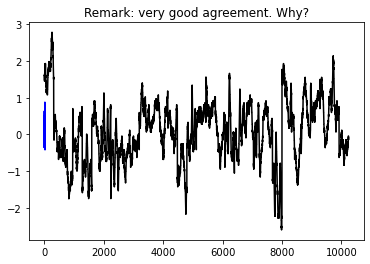

In [40]:
# Configure the RNN (LSTM) model
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

#  Plot the result to check the linear model
plt.plot(lstm_model(wide_window.example[0]).numpy().flatten(), 'b') 
plt.plot(wide_window.example[1].numpy().flatten(), 'k')
plt.title('Remark: very good agreement. Why?')
plt.show()

In [41]:
'''
# Estimate/construct the model
history_lstm = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

### It seems that the RNN cannot be run at CPU computers
### Tests from other websites
##batch_size = 100
##from tensorflow.keras import Sequential
##from tensorflow.keras.layers import LSTM, Dense
##from tensorflow.keras.optimizers import Adam
##
##model = Sequential()
##model.add(LSTM(100, batch_input_shape=(32, 320, 5), return_sequences=True))
##model.add(LSTM(100, return_sequences=True))
##model.add(LSTM(100))
##model.add(Dense(number_of_classes, activation='softmax'))
##
##model.summary()
##
##print("Created model.")
##
##model.compile(optimizer=Adam(lr=0.02),
##              loss='categorical_crossentropy', 
##              metrics=['acc'])
##
##print("Compiled model.")

'''

'\n# Estimate/construct the model\nhistory_lstm = compile_and_fit(lstm_model, wide_window)\n\nIPython.display.clear_output()\nval_performance[\'LSTM\'] = lstm_model.evaluate(wide_window.val)\nperformance[\'LSTM\'] = lstm_model.evaluate(wide_window.test, verbose=0)\n\n### It seems that the RNN cannot be run at CPU computers\n### Tests from other websites\n##batch_size = 100\n##from tensorflow.keras import Sequential\n##from tensorflow.keras.layers import LSTM, Dense\n##from tensorflow.keras.optimizers import Adam\n##\n##model = Sequential()\n##model.add(LSTM(100, batch_input_shape=(32, 320, 5), return_sequences=True))\n##model.add(LSTM(100, return_sequences=True))\n##model.add(LSTM(100))\n##model.add(Dense(number_of_classes, activation=\'softmax\'))\n##\n##model.summary()\n##\n##print("Created model.")\n##\n##model.compile(optimizer=Adam(lr=0.02),\n##              loss=\'categorical_crossentropy\', \n##              metrics=[\'acc\'])\n##\n##print("Compiled model.")\n\n'

# 7. Multi-step output models
**NB: different from Multi-output models that can be obtained by the previous code. Two rough approaches to this:**


* Single shot predictions where the entire time series is predicted at once.
* Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

## 7.1, Generate the dataset for the modelling
**NB: we will skip the baseline model in this example**

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

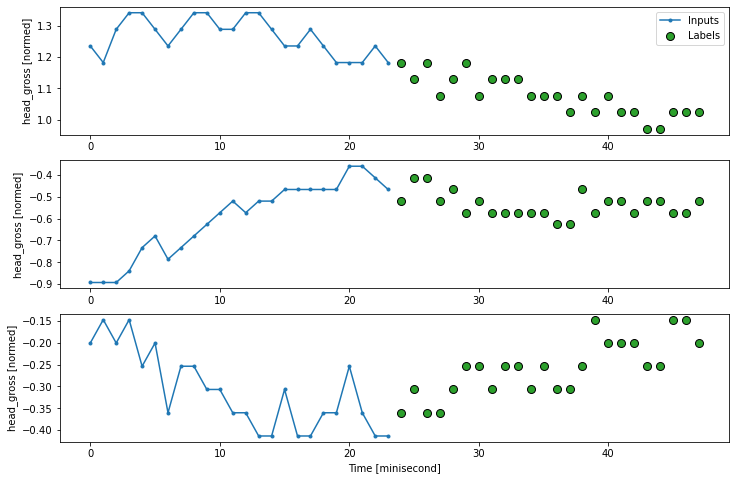

In [42]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

## 7.2 Illustration of various models for single-shot prediction
|base_future = last | base_future = repeated | linear/dense models |CNN | RNN|
|:-----:|:-----:|:-----:|:-----:|:-----:|
|![base_last](./images/multistep_baseline_last.png)|![base_repeat](./images/multistep_baseline_repeat.png)|![linear_dense](./images/multistep_linear_dense.png)|![cnn](./images/multistep_cnn.png)|![cnn](./images/multistep_rnn.png)|

### 7.2.1, Linear and dense model

2457/2457 [==============================] - 7s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0350


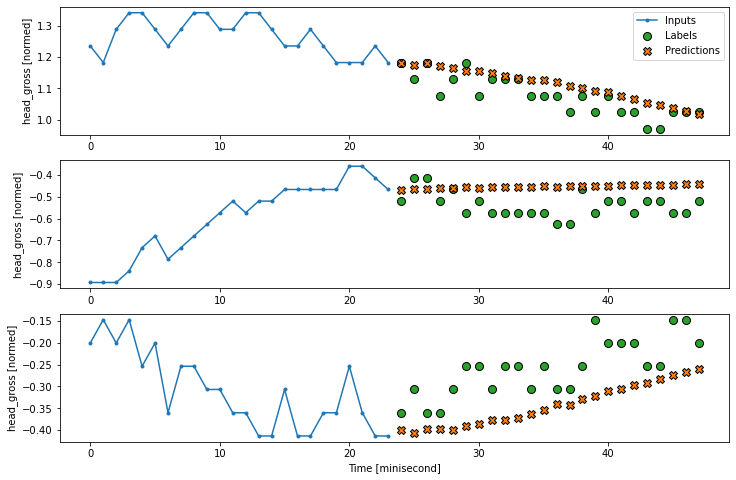

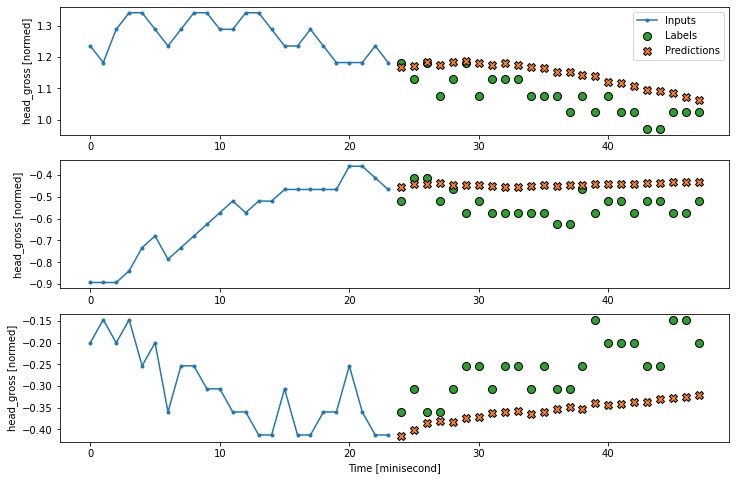

In [46]:
## Linear model
#num_features = df_train.shape[1]
#multi_linear_model = tf.keras.Sequential([
#    # Take the last time-step.
#    # Shape [batch, time, features] => [batch, 1, features]
#    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
#    # Shape => [batch, 1, out_steps*features]
#    tf.keras.layers.Dense(OUT_STEPS*num_features,
#                          kernel_initializer=tf.initializers.zeros()),
#    # Shape => [batch, out_steps, features]
#    tf.keras.layers.Reshape([OUT_STEPS, num_features])
#])
#
#history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance = {}
multi_performance = {}

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)



# Dense model
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

### 7.2.2, CNN model with conv length

2457/2457 [==============================] - 6s 3ms/step - loss: 0.0066 - mean_absolute_error: 0.0335


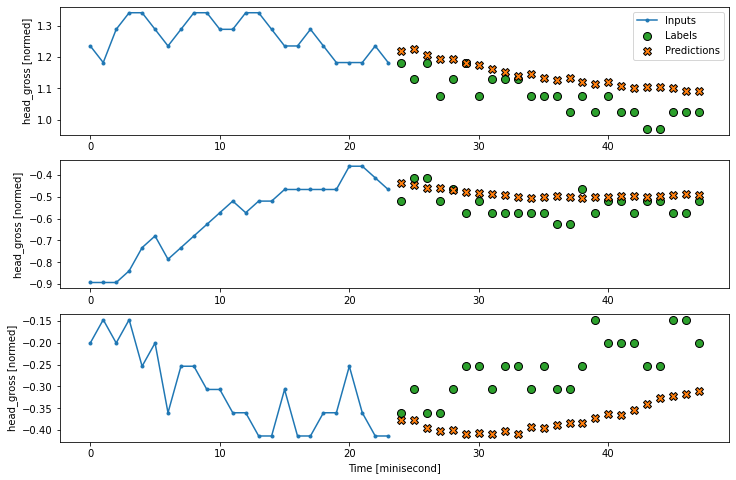

In [47]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

### 7.3.3, RNN (LSTM) model

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## 7.3 Illustration of autoregressive RNN model
![rnn_autoregressive](./images/multistep_rnn_autoregressive.png)

**Model description of autoregressive rnn model**

In [ ]:
# define the model
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)
    
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

# define the warm-up
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape


# get iteractive output
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)


# train the model
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)